In [3]:
# My code: using all three power spectra
# to change what's being output change the ini file
import sys
import os

parent = os.path.abspath("..")
sys.path.append(parent)

import numpy as np
import importlib
from configobj import ConfigObj
from TackleBox import Set_Bait, newFish, CovRenorm
from ioutils import CosmoResults, InputData, write_fisher
from scipy.linalg.lapack import dgesv


configpath = os.path.join(parent, "test.ini")

#configpath = os.path.join(parent, "test.ini")
pardict = ConfigObj(configpath)

# resolve inputfile relative to the ini file location
ini_dir = os.path.dirname(configpath)
inputfile_path = os.path.join(ini_dir, pardict["inputfile"])
pardict["inputfile"] = os.path.abspath(inputfile_path)

# Read in the file containing the redshift bins, nz and bias values
data = InputData(pardict)

if pardict.as_bool("withPV")==False:
    data.nzn=np.ones_like(data.nzn)*0.001

# Set up the linear power spectrum and derived parameters based on the input cosmology
cosmo = CosmoResults(pardict, data.zmin, data.zmax)
if np.any(data.volume > 0):
    cosmo.volume = data.volume * 1.0e9

# Convert the nz to nbar in (h/Mpc)^3
data.convert_nbar(cosmo.volume, float(pardict["skyarea"]))

# Scales the bias so that it goes as b/G(z)
if pardict.as_bool("scale_bias"):
    data.scale_bias(cosmo.growth)

# Precompute some things we might need for the Fisher matrix
recon, derPalpha, derPalpha_BAO_only = Set_Bait(cosmo, data, BAO_only=pardict.as_bool("BAO_only"))
#recon=np.ones_like(recon) #<-- uncomment this to do full recon

# Loop over redshifts and compute the Fisher matrix and output the 3x3 matrix
identity = np.eye(len(data.nbar) + 3)
title='FisherForecast'+str(len(cosmo.z))+'binBAO'+str(pardict.as_bool("BAO_only"))+'Recon'+str(int(recon[0]*100))+'PV'+str(pardict.as_bool("withPV"))+'.txt'
writepath='../Results/'
print(
    "   z    | V(Gpc/h)^3 |  nbar  | pvbar | recon | bias | kmin  | kmax  | fsigma8 +-err(%) | Da(Mpc/h) +-err(%) | H(km/s/Mpc) +-err(%) | +-alpha_err(%)"
)
with open(writepath+title,'w') as file:
    print(
        "   z    | V(Gpc/h)^3 |  nbar  | pvbar | recon | bias | kmin  | kmax  | fsigma8 +-err(%) | Da(Mpc/h) +-err(%) | H(km/s/Mpc) +-err(%) | +-alpha_err(%)", file=file)
erralpha = np.zeros(len(cosmo.z))
FullCatch = np.zeros((len(cosmo.z) * len(data.nbar) + 3, len(cosmo.z) * len(data.nbar) + 3))
for iz in range(len(cosmo.z)):

    if np.any(data.nz[:, iz] > 1.0e-30):

        Catch = newFish(
            cosmo,
            cosmo.kmin,
            cosmo.kmax,
            data,
            iz,
            recon[iz],
            derPalpha,
            pardict.as_bool("BAO_only"),
        )

        # Add on BAO only information from kmax to k = 0.5 Mpc/h but only for alpha_perp and alpha_par
        ExtraCatch = newFish(
            cosmo,
            cosmo.kmax,
            np.repeat(0.5,len(cosmo.z)),
            data,
            iz,
            recon[iz],
            derPalpha_BAO_only,
            True,
        )
        Catch[-2:, -2:] += ExtraCatch[-2:, -2:]

        # Add the Fisher matrix to the full fisher matrix
        FullCatch[
            iz * len(data.nbar) : (iz + 1) * len(data.nbar),
            iz * len(data.nbar) : (iz + 1) * len(data.nbar),
        ] += Catch[: len(data.nbar), : len(data.nbar)]
        FullCatch[iz * len(data.nbar) : (iz + 1) * len(data.nbar), -3:,] += Catch[: len(data.nbar), -3:]
        FullCatch[-3:, iz * len(data.nbar) : (iz + 1) * len(data.nbar)] += Catch[-3:, : len(data.nbar)]
        FullCatch[-3:, -3:] += Catch[-3:, -3:]

        # Invert the Fisher matrix to get the parameter covariance matrix
        cov = dgesv(Catch, identity)[2]

        # Compute the error on isotropic alpha also
        J = np.array([2.0 / 3.0, 1.0 / 3.0])
        erralpha[iz] = 100.0 * np.sqrt(J @ cov[-2:, -2:] @ J.T)

        # Renormalise the covariance from fsigma8, alpha_perp, alpha_par to fsigma8, Da, H
        means = np.array([cosmo.f[iz] * cosmo.sigma8[iz], cosmo.da[iz], cosmo.h[iz]])
        cov_renorm = CovRenorm(cov, means)

        # Print the parameter means and errors
        errs = 100.0 * np.sqrt(np.diag(cov_renorm)[-3:]) / means
        print(
            "  {0:5.3f} | {1:10.4f} | {2:6.3f} | {3:5.3f} | {4:5.1f} | {5:4.2f} | {6:5.3f} | {7:5.3f} | {8:6.3f} +- {9:5.2f}% |"
            " {10:7.1f} +- {11:6.2f}% | {12:8.1f} +- {13:7.2f}% | +- {14:6.2f}%".format(
                cosmo.z[iz],
                cosmo.volume[iz] / 1e9,
                data.nbar[0, iz],
                data.nbarz[0, iz],
                recon[iz],
                data.bias[0, iz],
                cosmo.kmin[iz],
                cosmo.kmax[iz],
                means[0],
                errs[0],
                means[1],
                errs[1],
                means[2],
                errs[2],
                erralpha[iz],
            )
            #z  V(Gpc/h)^3  fsigma8  fsigma8_err(%)  Da(Mpc/h)  Da_err(%)  H(km/s/Mpc)  H_err(%)   alpha_err(%)"
            #  z  |  V(Gpc/h)^3  |  nbar  |  pvbar  |  recon  |  bias  |  kmin  |  kmax  |  fsigma8  -  err(%)  |  Da(Mpc/h)  -  err(%)  |  H(km/s/Mpc)  -  err(%)  |  alpha_err(%)"
        )
        with open(writepath+title,'a') as file:
            print(
            "  {0:5.3f} | {1:10.4f} | {2:6.3f} | {3:5.3f} | {4:5.1f} | {5:4.2f} | {6:5.3f} | {7:5.3f} | {8:6.3f} +- {9:5.2f}% |"
            " {10:7.1f} +- {11:6.2f}% | {12:8.1f} +- {13:7.2f}% | +- {14:6.2f}%".format(
                cosmo.z[iz],
                cosmo.volume[iz] / 1e9,
                data.nbar[0, iz],
                data.nbarz[0, iz],
                recon[iz],
                data.bias[0, iz],
                cosmo.kmin[iz],
                cosmo.kmax[iz],
                means[0],
                errs[0],
                means[1],
                errs[1],
                means[2],
                errs[2],
                erralpha[iz],
            ), file=file
        )

    else:
        print('No data')

# Run the cosmological parameters at the centre of the combined redshift bin
identity = np.eye(len(cosmo.z) * len(data.nbar) + 3)
cosmo = CosmoResults(pardict, np.atleast_1d(data.zmin[0]), np.atleast_1d(data.zmax[-1]))

# Invert the Combined Fisher matrix to get the parameter
# covariance matrix and compute means and errors
cov = dgesv(FullCatch, identity)[2]
J = np.array([2.0 / 3.0, 1.0 / 3.0])
erralpha = 100.0 * np.sqrt(J @ cov[-2:, -2:] @ J.T)
means = np.array([cosmo.f[0] * cosmo.sigma8[0], cosmo.da[0], cosmo.h[0]])
cov_renorm = CovRenorm(cov, means)
errs = 100.0 * np.sqrt(np.diag(cov_renorm)[-3:]) / means
print("====================================================================================================================================================")
print(
    "  {0:5.3f} | {1:10.4f} | {2:^6} | {3:^5} | {4:^5} | {5:^4} | {6:^5} | {7:^5} | {8:6.3f} +- {9:5.2f}% |"
    " {10:7.1f} +- {11:6.2f}% | {12:8.1f} +- {13:7.2f}% | +- {14:6.2f}%".format(
        cosmo.z[0],
        cosmo.volume[0] / 1e9,
        "-----",
        "-----",
        "---",
        "----",
        "-----",
        "-----",
        means[0],
        errs[0],
        means[1],
        errs[1],
        means[2],
        errs[2],
        erralpha,
    )
)
with open(writepath+title,'a') as file:
    print("====================================================================================================================================================",file=file)
    print(
        "  {0:5.3f} | {1:10.4f} | {2:^6} | {3:^5} | {4:^5} | {5:^4} | {6:^5} | {7:^5} | {8:6.3f} +- {9:5.2f}% |"
        " {10:7.1f} +- {11:6.2f}% | {12:8.1f} +- {13:7.2f}% | +- {14:6.2f}%".format(
            cosmo.z[0],
            cosmo.volume[0] / 1e9,
            "-----",
            "-----",
            "---",
            "----",
            "-----",
            "-----",
            means[0],
            errs[0],
            means[1],
            errs[1],
            means[2],
            errs[2],
            erralpha,
        ), file=file
    )

   z    | V(Gpc/h)^3 |  nbar  | pvbar | recon | bias | kmin  | kmax  | fsigma8 +-err(%) | Da(Mpc/h) +-err(%) | H(km/s/Mpc) +-err(%) | +-alpha_err(%)
  0.025 |     0.0046 |  0.046 | 0.011 |   0.5 | 1.36 | 0.030 | 0.100 |  0.435 +- 10.75% |   107.9 +-  12.59% |     68.2 +-    9.33% | +-   7.46%
  0.075 |     0.0310 |  0.046 | 0.003 |   0.5 | 1.39 | 0.019 | 0.100 |  0.446 +- 11.80% |   304.9 +-   6.99% |     69.9 +-   14.12% | +-   5.13%
  0.050 |     0.0356 | -----  | ----- |  ---  | ---- | ----- | ----- |  0.441 +-  7.93% |   209.4 +-   6.01% |     69.0 +-    7.53% | +-   3.83%


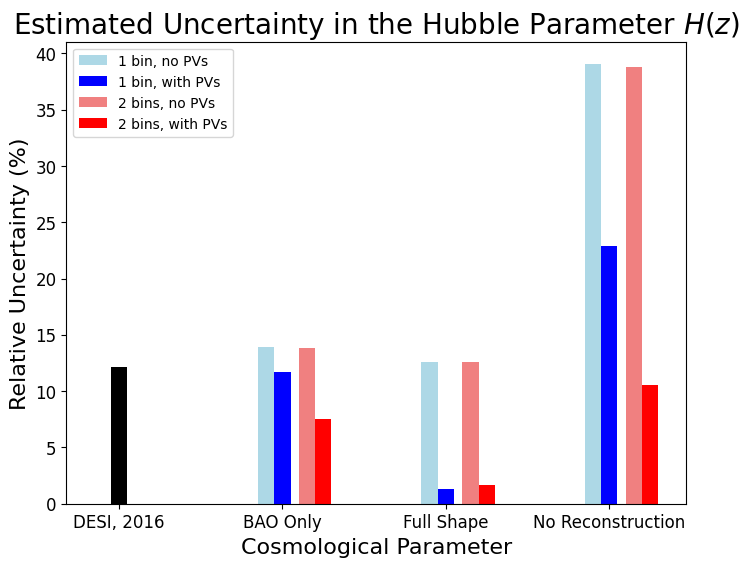

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

labels = ['DESI, 2016','BAO Only','Full Shape','No Reconstruction']#['f$\sigma_8$', 'D$_A$', 'H']#['DESI, 2016','1 bin, no PVs','1 bin, with PVs','2 bins, no PVs','2 bins, with PVs']
desi = [12.1,0,0,0]#[33.24, 6.12, 12.1]#
colors = ['lightblue','b','lightcoral','r']

# recon = 1
no11 = [40.546, 15.295, 39.076]
no21 = [40.683, 15.090, 38.763]
pv11 = [7.847, 14.102, 22.848]
pv21 = [9.418, 11.920, 10.584]

# bao only = true
no12 = [31.64, 6.65, 13.92]
no22 = [31.74, 6.60, 13.86]
pv12 = [6.83, 6.48, 11.73]
pv22 = [7.93, 6.01, 7.53]

# bao only = false
no13 = [40.448, 6.256, 12.584]
no23 = [40.564, 6.225, 12.554]
pv13 = [7.380, 1.636, 1.287]
pv23 = [8.220, 1.289, 1.635]

no1=[0,no12[-1],no13[-1],no11[-1]]
no2=[0,no22[-1],no23[-1],no21[-1]]
pv1=[0,pv12[-1],pv13[-1],pv11[-1]]
pv2=[0,pv22[-1],pv23[-1],pv21[-1]]

x = np.arange(len(labels)) 
width = 0.1 

fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x,desi,width,color='k')
#ax.bar(x,desi+no1+pv1+no2+pv2,width,color=colors)
#ax.bar(x - 2*width-0.05, desi, width, label='DESI, 2016',color='k')
ax.bar(x - width, no1, width, label='1 bin, no PVs',color='lightblue')
ax.bar(x, pv1, width, label='1 bin, with PVs',color='b')
ax.bar(x + width+0.05, no2, width, label='2 bins, no PVs',color='lightcoral')
ax.bar(x + 2*width+0.05, pv2, width, label='2 bins, with PVs',color='r')

ax.set_ylabel('Relative Uncertainty (%)',fontsize=16)
#ax.set_ylim(0,18)
ax.set_title('Estimated Uncertainty in the Hubble Parameter $H(z)$',fontsize=20)
ax.set_xlabel('Cosmological Parameter',fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(labels,fontsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.legend()

plt.tight_layout()
path='../Figures/FullH.png'
plt.savefig(path, dpi=300,bbox_inches='tight')
plt.close()

In [27]:
from TackleBox import get_powerfx, get_inv_cov,get_full_deriv,compute_deriv_alphas
from scipy.interpolate import splrep, splev
kvec = np.linspace(0.001,0.1,100)
muvec = np.linspace(-1,1,200)
pgg=np.zeros((len(kvec),len(muvec))) #400x100 array to contain value of pgg at each k and mu value
pgu=np.zeros((len(kvec),len(muvec))) #400x100 array to contain value of pgu at each k and mu value
puu=np.zeros((len(kvec),len(muvec))) #400x100 array to contain value of puu at each k and mu value
cov=np.zeros((3,3,len(kvec),len(muvec))) # covariance info, 3x3 for Pgg Pgu Puu and then k and mu
invcov=np.zeros((3,3,len(kvec),len(muvec))) # inverse covariance info
bder=np.zeros((3,len(kvec),len(muvec))) #400x100 array to contain derivative of pgg, pgu, pgg wrt b at each k and mu value
fder=np.zeros((3,len(kvec),len(muvec))) #400x100 array to contain derivative of pgg, pgu, pgg wrt f at each k and mu value
aperder=np.zeros((3,len(kvec),len(muvec))) #400x100 array to contain derivative of pgg, pgu, pgg wrt aperp at each k and mu value
aparder=np.zeros((3,len(kvec),len(muvec))) #400x100 array to contain derivative of pgg, pgu, pgg wrt apara at each k and mu value

In [28]:
pkval = splev(kvec, cosmo.pk[0])
pksmoothval = splev(kvec, cosmo.pksmooth[0])
npop = np.shape(data.nbar)[0]
npk = int(npop*(npop+1)/2)
coords = [[kval, muval] for kval in kvec for muval in muvec]
kaiser = np.tile(data.bias[:, 0], (len(muvec), 1)).T + cosmo.f[0] * muvec ** 2
derPalpha = compute_deriv_alphas(cosmo,BAO_only=False)
coords = [[kval, muval] for kval in kvec for muval in muvec]
derPalphaval = np.array([
derPalpha[i](coords).reshape(len(kvec), len(muvec)) * (cosmo.sigma8[0] / cosmo.sigma8[0]) ** 2
for i in range(2)])

In [36]:
for i, kval in enumerate(kvec):
    for j, muval in enumerate(muvec):
        # Grab relevant constans
        fval,zval,hval,daval,sigmaval=cosmo.f[0],cosmo.z[0],cosmo.h[0],cosmo.da[0],cosmo.sigma8[0]
        nbarval,zbarval,pverrval=data.nbar[0,0],data.nbarz[0,0],data.pverr[0,0]

        # Grab power functions
        pgg[i,j],pgu[i,j],puu[i,j]=get_powerfx(kval,muval,pkval[i],kaiser[:,j],fval,zval,hval)

        # Grab derivatives, scale with damping factors
        bder[:,i,j],fder[:,i,j],aperder[:,i,j],aparder[:,i,j]=get_full_deriv(kval,muval,pkval[i],pksmoothval[i],kaiser[:,j],fval,zval,hval,derPalphaval[:,i,j],sigmaval,True).T
        #derP*=np.tile([Dfactor[j,i],Dfactor[j,i],Dfactor[j,i]],(4,1)).T
        
        # Grab covariance matrices
        cov[:,:,i,j],invcov[:,:,i,j]=get_inv_cov(pgg[i,j],pgu[i,j],puu[i,j],nbarval,zbarval,pverrval,daval,cosmo.h[0],zval)

/tmp/ipykernel_327136/3992696413.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pgg[i,j],pgu[i,j],puu[i,j]=get_powerfx(kval,muval,pkval[i],kaiser[:,j],fval,zval,hval)


In [56]:
import matplotlib.pyplot as plt
fig,axes=plt.subplots(3,1,figsize=(6,18))
axes.flatten()
s=2
muidx=199
factor=(2*np.pi**2)/(cosmo.volume[0]*kvec**2*(kvec[1]-kvec[0]))
axes[0].errorbar(kvec[::s],pgg[:,muidx][::s],yerr=np.sqrt(factor*cov[0,0,:,muidx])[::s],fmt='.',color='b')
axes[1].errorbar(kvec[::s],(pgu[:,muidx]*kvec)[::s],yerr=(np.sqrt(factor*cov[1,1,:,muidx])*kvec)[::s],fmt='.',color='r')
axes[2].errorbar(kvec[::s],(puu[:,muidx]*kvec**2)[::s],yerr=(np.sqrt(factor*cov[2,2,:,muidx])*kvec**2)[::s],fmt='.',color='g')
axes[0].plot(kvec,pgg[:,muidx],color='b')
axes[1].plot(kvec,pgu[:,muidx]*kvec,color='r')
axes[2].plot(kvec,puu[:,muidx]*kvec**2,color='g')
axes[0].set_title('$P_{gg}$ with error at $\mu=1$',fontsize=16)
axes[1].set_title('$P_{gu}$ with error $\mu=1$',fontsize=16)
axes[2].set_title('$P_{uu}$ with error $\mu=1$',fontsize=16)
axes[0].set_xlabel('k (h Mpc$^{-1}$)',fontsize=12,labelpad=-3)
axes[1].set_xlabel('k (h Mpc$^{-1}$)',fontsize=12,labelpad=-3)
axes[2].set_xlabel('k (h Mpc$^{-1}$)',fontsize=12,labelpad=-3)
axes[0].set_ylabel('$P_{gg}$',fontsize=14,labelpad=-30)
axes[1].set_ylabel('$P_{gu}k$',fontsize=14,labelpad=-5)
axes[2].set_ylabel('$P_{uu}k^2$',fontsize=14,labelpad=0)
path = '../Figures/FinalFinalPower.png'
plt.savefig(path, dpi=300,bbox_inches='tight')
plt.close() 

In [57]:
muidx=149
fig,axes=plt.subplots(3,1,figsize=(6,18))
axes.flatten()
axes[0].plot(kvec,bder[0,:,muidx]/pgg[:,muidx],label='b')
axes[0].plot(kvec,fder[0,:,muidx]/pgg[:,muidx],label='f',linestyle='--')
axes[0].plot(kvec,aperder[0,:,muidx]/pgg[:,muidx],label='$\\alpha_{\perp}$')
axes[0].plot(kvec,aparder[0,:,muidx]/pgg[:,muidx],label='$\\alpha_{\parallel}$',linestyle='--')
axes[0].set_ylabel('$\\frac{1}{P_{gg}}$ $\\frac{dP_{gg}}{d\\theta_i}$',fontsize=16,labelpad=-3)
axes[0].set_xlabel('k (h Mpc$^{-1}$)',fontsize=12,labelpad=-3)
axes[0].set_title('Derivatives of $P_{{gg}}$ at $\mu={:.1f}$'.format(muvec[muidx]),fontsize=16)
axes[0].legend()
axes[1].plot(kvec,bder[1,:,muidx]/pgu[:,muidx],label='b')
axes[1].plot(kvec,fder[1,:,muidx]/pgu[:,muidx],label='f',linestyle='--')
axes[1].plot(kvec,aperder[1,:,muidx]/pgu[:,muidx],label='$\\alpha_{\perp}$')
axes[1].plot(kvec,aparder[1,:,muidx]/pgu[:,muidx],label='$\\alpha_{\parallel}$',linestyle='--')
axes[1].set_ylabel('$\\frac{1}{P_{gu}}$ $\\frac{dP_{gu}}{d\\theta_i}$',fontsize=16,labelpad=-3)
axes[1].set_xlabel('k (h Mpc$^{-1}$)',fontsize=12,labelpad=-3)
axes[1].set_title('Derivatives of $P_{{gu}}$ at $\mu={:.1f}$'.format(muvec[muidx]),fontsize=16)
axes[1].legend()
axes[2].plot(kvec,bder[2,:,muidx]/puu[:,muidx],label='b')
axes[2].plot(kvec,fder[2,:,muidx]/puu[:,muidx],label='f',linestyle='--')
axes[2].plot(kvec,aperder[2,:,muidx]/puu[:,muidx],label='$\\alpha_{\perp}$')
axes[2].plot(kvec,aparder[2,:,muidx]/puu[:,muidx],label='$\\alpha_{\parallel}$',linestyle='--')
axes[2].set_ylabel('$\\frac{1}{P_{uu}}$ $\\frac{dP_{uu}}{d\\theta_i}$',fontsize=16,labelpad=-3)
axes[2].set_xlabel('k (h Mpc$^{-1}$)',fontsize=12,labelpad=-3)
axes[2].set_title('Derivatives of $P_{{uu}}$ at $\mu={:.1f}$'.format(muvec[muidx]),fontsize=16)
axes[2].legend()
path = '../Figures/FinalFinalDerivatives.png'
plt.savefig(path, dpi=300,bbox_inches='tight')
plt.close()

In [ ]:
import scipy.integrate
results1=scipy.integrate.simpson(pgg,muvec,axis=1)
results2=scipy.integrate.simpson(pgu,muvec,axis=1)
results3=scipy.integrate.simpson(puu,muvec,axis=1)
import matplotlib.pyplot as plt
fig,axes=plt.subplots(3,1,figsize=(6,18))
axes.flatten()
factor=(2*np.pi**2)/(vol*kval**2*(kvec[1]-kvec[0]))
ps=pverr*da*hval
cgg=factor*2*(results1+1/nbarval)**2
cgu=factor*(results1+1/nbarval)*(results3+ps**2/vbarval)+results2**2
cuu=factor*2*(results3+ps**2/vbarval)**2
s=8
#axes[0].errorbar(kvec[::5],(results1*kvec)[::5],yerr=(np.sqrt(cgg)*kvec)[::5],fmt='.',color='b')
axes[0].errorbar(kvec[::s],results1[::s],yerr=np.sqrt(cgg)[::s],fmt='.',color='b')
axes[1].errorbar(kvec[::s],(results2*kvec)[::s],yerr=(np.sqrt(cgu)*kvec)[::s],fmt='.',color='r')
axes[2].errorbar(kvec[::s],(results3*kvec**2)[::s],yerr=(np.sqrt(cuu)*kvec**2)[::s],fmt='.',color='g')
axes[0].plot(kvec,results1,color='b')
axes[1].plot(kvec,results2*kvec,color='r')
axes[2].plot(kvec,results3*kvec**2,color='g')
axes[0].set_title('$P_{gg}$ with error',fontsize=16)
axes[1].set_title('$P_{gu}$ with error',fontsize=16)
axes[2].set_title('$P_{uu}$ with error',fontsize=16)
axes[0].set_xlabel('k (h Mpc$^{-1}$)',fontsize=12,labelpad=-3)
axes[1].set_xlabel('k (h Mpc$^{-1}$)',fontsize=12,labelpad=-3)
axes[2].set_xlabel('k (h Mpc$^{-1}$)',fontsize=12,labelpad=-3)
axes[0].set_ylabel('$P_{gg}$',fontsize=14,labelpad=-5)
axes[1].set_ylabel('$P_{gu}k$',fontsize=14,labelpad=-20)
axes[2].set_ylabel('$P_{uu}k^2$',fontsize=14,labelpad=2)
path = '../Figures/FinalPower.png'
plt.savefig(path, dpi=300,bbox_inches='tight')
plt.close() # do a single mu of .5 or 1

In [77]:
newbder=scipy.integrate.simpson(bder,muvec,axis=2)
newfder=scipy.integrate.simpson(fder,muvec,axis=2)
newapder=scipy.integrate.simpson(aperder,muvec,axis=2)
newalder=scipy.integrate.simpson(aparder,muvec,axis=2)
fig,axes=plt.subplots(3,1,figsize=(6,18))
axes.flatten()
axes[0].plot(kvec,newbder[0,:]/results1,label='b$\sigma_8$')
axes[0].plot(kvec,newfder[0,:]/results1,label='f$\sigma_8$',linestyle='--')
axes[0].plot(kvec,newapder[0,:]/results1,label='$\\alpha_{\perp}$')
axes[0].plot(kvec,newalder[0,:]/results1,label='$\\alpha_{\parallel}$',linestyle='--')
axes[0].set_ylabel('$\\frac{1}{P_{gg}}$ $\\frac{dP_{gg}}{d\\theta_i}$',fontsize=16,labelpad=-3)
axes[0].set_xlabel('k (h Mpc$^{-1}$)',fontsize=12,labelpad=-3)
axes[0].set_title('Derivatives of $P_{{gg}}$',fontsize=16)
axes[0].legend()
axes[1].plot(kvec,newbder[1,:]/results2,label='b$\sigma_8$')
axes[1].plot(kvec,newfder[1,:]/results2,label='f$\sigma_8$',linestyle='--')
axes[1].plot(kvec,newapder[1,:]/results2,label='$\\alpha_{\perp}$')
axes[1].plot(kvec,newalder[1,:]/results2,label='$\\alpha_{\parallel}$',linestyle='--')
axes[1].set_ylabel('$\\frac{1}{P_{gu}}$ $\\frac{dP_{gu}}{d\\theta_i}$',fontsize=16,labelpad=-3)
axes[1].set_xlabel('k (h Mpc$^{-1}$)',fontsize=12,labelpad=-3)
axes[1].set_title('Derivatives of $P_{{gu}}$',fontsize=16)
axes[1].legend()
axes[2].plot(kvec,newbder[2,:]/results3,label='b$\sigma_8$')
axes[2].plot(kvec,newfder[2,:]/results3,label='f$\sigma_8$',linestyle='--')
axes[2].plot(kvec,newapder[2,:]/results3,label='$\\alpha_{\perp}$')
axes[2].plot(kvec,newalder[2,:]/results3,label='$\\alpha_{\parallel}$',linestyle='--')
axes[2].set_ylabel('$\\frac{1}{P_{uu}}$ $\\frac{dP_{uu}}{d\\theta_i}$',fontsize=16,labelpad=-3)
axes[2].set_xlabel('k (h Mpc$^{-1}$)',fontsize=12,labelpad=-3)
axes[2].set_title('Derivatives of $P_{{uu}}$',fontsize=16)
axes[2].legend()
path = '../Figures/FinalDerivatives.png'
plt.savefig(path, dpi=300,bbox_inches='tight')
plt.close()

OLD CODE...

In [ ]:
## Cullan's code: only using Pgg info
import sys
import os
parent = os.path.abspath("..")
sys.path.append(parent)
configpath = os.path.join(parent, "test.ini")
import numpy as np
import importlib
from configobj import ConfigObj
from TackleBox import Set_Bait, Fish, CovRenorm
from ioutils import CosmoResults, InputData, write_fisher
from scipy.linalg.lapack import dgesv

if __name__ == "__main__":

    configpath = os.path.join(parent, "test.ini")
    pardict = ConfigObj(configpath)

    # resolve inputfile relative to the ini file location
    ini_dir = os.path.dirname(configpath)
    inputfile_path = os.path.join(ini_dir, pardict["inputfile"])
    pardict["inputfile"] = os.path.abspath(inputfile_path)

    #pardict = ConfigObj(configpath)

    # Read in the file containing the redshift bins, nz and bias values
    data = InputData(pardict)

    # Set up the linear power spectrum and derived parameters based on the input cosmology
    cosmo = CosmoResults(pardict, data.zmin, data.zmax)
    if np.any(data.volume > 0):
        cosmo.volume = data.volume * 1.0e9

    # Convert the nz to nbar in (h/Mpc)^3
    data.convert_nbar(cosmo.volume, float(pardict["skyarea"]))

    # Scales the bias so that it goes as b/G(z)
    if pardict.as_bool("scale_bias"):
        data.scale_bias(cosmo.growth)
    print("#  Data nbar")
    print(data.nbar, data.nbarz)
    print("#  Data bias")
    print(data.bias)

    # Precompute some things we might need for the Fisher matrix
    recon, derPalpha, derPalpha_BAO_only = Set_Bait(cosmo, data, BAO_only=pardict.as_bool("BAO_only"))
    print("#  Data recon factor")
    print(recon)

    # Loop over redshifts and compute the Fisher matrix and output the 3x3 matrix
    identity = np.eye(len(data.nbar) + 3)
    print(
        "#  z  V(Gpc/h)^3  fsigma8  fsigma8_err(%)  Da(Mpc/h)  Da_err(%)  H(km/s/Mpc)  H_err(%)   alpha_err(%)"
    )
    erralpha = np.zeros(len(cosmo.z))
    FullCatch = np.zeros((len(cosmo.z) * len(data.nbar) + 3, len(cosmo.z) * len(data.nbar) + 3))
    for iz in range(len(cosmo.z)):

        if np.any(data.nz[:, iz] > 1.0e-30):

            Catch = Fish(
                cosmo,
                cosmo.kmin[iz],
                cosmo.kmax[iz],
                data,
                iz,
                recon[iz],
                derPalpha,
                pardict.as_bool("BAO_only"),
                pardict.as_bool("GoFast"),
            )

            # Add on BAO only information from kmax to k = 0.5 Mpc/h but only for alpha_perp and alpha_par
            ExtraCatch = Fish(
                cosmo,
                cosmo.kmax[iz],
                0.5,
                data,
                iz,
                recon[iz],
                derPalpha_BAO_only,
                True,
                pardict.as_bool("GoFast"),
            )
            Catch[-2:, -2:] += ExtraCatch[-2:, -2:]

            # Add the Fisher matrix to the full fisher matrix
            FullCatch[
                iz * len(data.nbar) : (iz + 1) * len(data.nbar),
                iz * len(data.nbar) : (iz + 1) * len(data.nbar),
            ] += Catch[: len(data.nbar), : len(data.nbar)]
            FullCatch[iz * len(data.nbar) : (iz + 1) * len(data.nbar), -3:,] += Catch[: len(data.nbar), -3:]
            FullCatch[-3:, iz * len(data.nbar) : (iz + 1) * len(data.nbar)] += Catch[-3:, : len(data.nbar)]
            FullCatch[-3:, -3:] += Catch[-3:, -3:]

            # Invert the Fisher matrix to get the parameter covariance matrix
            cov = dgesv(Catch, identity)[2]

            # Compute the error on isotropic alpha also
            J = np.array([2.0 / 3.0, 1.0 / 3.0])
            erralpha[iz] = 100.0 * np.sqrt(J @ cov[-2:, -2:] @ J.T)

            # Renormalise the covariance from fsigma8, alpha_perp, alpha_par to fsigma8, Da, H
            means = np.array([cosmo.f[iz] * cosmo.sigma8[iz], cosmo.da[iz], cosmo.h[iz]])
            cov_renorm = CovRenorm(cov, means)

            # Print the parameter means and errors
            errs = 100.0 * np.sqrt(np.diag(cov_renorm)[-3:]) / means
            print(
                " {0:.3f}    {1:.4f}     {2:.3f}       {3:.2f}         {4:.1f}       {5:.2f}        {6:.1f}       {7:.2f}       {8:.3f}".format(
                    cosmo.z[iz],
                    cosmo.volume[iz] / 1e9,
                    means[0],
                    errs[0],
                    means[1],
                    errs[1],
                    means[2],
                    errs[2],
                    erralpha[iz],
                )
                #z  V(Gpc/h)^3  fsigma8  fsigma8_err(%)  Da(Mpc/h)  Da_err(%)  H(km/s/Mpc)  H_err(%)   alpha_err(%)"
            )

            # Output the fisher matrix for the redshift bin
            write_fisher(pardict, cov_renorm, cosmo.z[iz], means)

        else:
            erralpha[iz] = 1.0e30
            print(
                " {0:.3f}     {1:.4f}    {2:.3f}         -          {4:.1f}         -         {6:.1f}         -          -".format(
                    cosmo.z[iz],
                    cosmo.volume[iz] / 1e9,
                    means[0],
                    errs[0],
                    means[1],
                    errs[1],
                    means[2],
                    errs[2],
                    erralpha[iz],
                )
            )

    # Run the cosmological parameters at the centre of the combined redshift bin
    identity = np.eye(len(cosmo.z) * len(data.nbar) + 3)
    cosmo = CosmoResults(pardict, np.atleast_1d(data.zmin[0]), np.atleast_1d(data.zmax[-1]))

    # Invert the Combined Fisher matrix to get the parameter
    # covariance matrix and compute means and errors
    cov = dgesv(FullCatch, identity)[2]
    J = np.array([2.0 / 3.0, 1.0 / 3.0])
    erralpha = 100.0 * np.sqrt(J @ cov[-2:, -2:] @ J.T)
    means = np.array([cosmo.f[0] * cosmo.sigma8[0], cosmo.da[0], cosmo.h[0]])
    cov_renorm = CovRenorm(cov, means)
    errs = 100.0 * np.sqrt(np.diag(cov_renorm)[-3:]) / means
    print("#  Combined errors")
    print("#=================")
    print(
        " {0:.2f}    {1:.4f}     {2:.3f}       {3:.3f}         {4:.2f}       {5:.3f}        {6:.2f}       {7:.3f}       {8:.3f}".format(
            cosmo.z[0],
            cosmo.volume[0] / 1e9,
            means[0],
            errs[0],
            means[1],
            errs[1],
            means[2],
            errs[2],
            erralpha,
        )
    )

In [ ]:
for i in range(100):
    plt.errorbar(kvec[::5],(pgu[:,i]*kvec)[::5],yerr=(np.sqrt(cov[1,1,:,i])*kvec)[::5])
    plt.title('P$_{{gu}}$ with errorbars at $\mu$={:.2f}'.format(muvec[i]))
    plt.ylabel('$P_{gu}k$')
    plt.xlabel('k (h Mpc$^{-1})$')
    plt.ylim(-10000,3.5e7)
    path = '../../Data/Pgu/{:03d}.png'.format(i)
    plt.savefig(path, dpi=300)
    plt.close()

<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_419332/788185335.py:3: SyntaxWarning: invalid escape sequence '\m'
  plt.title('P$_{{gu}}$ with errorbars at $\mu$={:.2f}'.format(muvec[i]))


In [ ]:
from PIL import Image, ImageDraw
folder_path = "../../Data/Pgu"
output_folder = "../Figures"
output_gif = os.path.join(output_folder, "Pgu moving errorbars.gif")
image_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith(('.png', '.jpg', '.jpeg'))]
image_files.sort()
images = [Image.open(img) for img in image_files]
images[0].save(output_gif, save_all=True, append_images=images[1:], duration=100, loop=0)